In [1]:
import gym
from gym import spaces
import numpy as np
from scipy.integrate import solve_ivp

class MissileGuidanceEnv(gym.Env):
    def __init__(self, logging=False):
        super(MissileGuidanceEnv, self).__init__()

        # Simulation parameters 
        self.dt = 0.01  # Fixed time step
        self.VM = 600   # Missile velocity (m/s)
        self.VT = 400   # Target velocity (m/s)
        self.a_max = 100  # Max missile acceleration (m/s²)
        self.time = 0.0

        self.logging = logging

        # Define action and observation space
        self.action_space = spaces.Box(low=-self.a_max, high=self.a_max, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([0, -np.pi, -1000, -10]),
            high=np.array([50000, np.pi, 1000, 10]),
            dtype=np.float32
        )

        if self.logging:
            self._init_logs()

    def _init_logs(self):
        self.time_log = []
        self.range_log = []
        self.lambda_log = []
        self.r_dot_log = []
        self.lambda_dot_log = []
        self.aM_log = []
        self.gammaM_log = []
        self.gammaT_log = []
        self.xM_log = [0]
        self.yM_log = [0]
        self.xT_log = []
        self.yT_log = []


    def reset(self):
        # Randomize initial conditions
        self.r = np.random.uniform(4000, 6000)  # Range (meters)
        self.lambda_ = np.radians(np.random.uniform(-10, 10))  # LOS angle (radians)
        self.gammaM = np.radians(np.random.uniform(0, 20))  # Missile flight path angle (radians)
        self.gammaT = np.radians(np.random.uniform(140, 160))  # Target flight path angle (radians)
        self.tau = np.random.uniform(0.1, 0.3)  # Missile autopilot lag (seconds)
        self.aM = 0.0  # Initial lateral acceleration

        if self.logging:
            self._init_logs()

        return self._get_state()

    def step(self, action):
        ac = np.clip(action[0], -self.a_max, self.a_max)  # Clip action to allowable range
        y0 = [self.r, self.lambda_, self.gammaM, self.aM]

        # Define dynamics function
        def dynamics(t, y):
            r, lambda_, gammaM, aM = y

            aM_dot = (-aM + ac) / self.tau
            gammaM_dot = aM / self.VM

            Vr = self.VT * np.cos(self.gammaT - lambda_) - self.VM * np.cos(gammaM - lambda_)
            Vlambda = self.VT * np.sin(self.gammaT - lambda_) - self.VM * np.sin(gammaM - lambda_)

            r_dot = Vr
            lambda_dot = Vlambda / self.r if self.r > 0.01 else Vlambda / 0.01

            return [r_dot, lambda_dot, gammaM_dot, aM_dot]

        # Solve the ODE over one time step
        sol = solve_ivp(dynamics, (0, self.dt), y0, method='RK45', t_eval=[self.dt])
        self.r, self.lambda_, self.gammaM, self.aM = sol.y[:, -1]
        self.time += self.dt

        # If logging enabled, record data
        if self.logging:
            Vr = self.VT * np.cos(self.gammaT - self.lambda_) - self.VM * np.cos(self.gammaM - self.lambda_)
            Vlambda = self.VT * np.sin(self.gammaT - self.lambda_) - self.VM * np.sin(self.gammaM - self.lambda_)

            r_dot = Vr
            lambda_dot = Vlambda / self.r if self.r > 0.01 else Vlambda / 0.01

            self.time_log.append(self.time)
            self.range_log.append(self.r)
            self.lambda_log.append(self.lambda_)
            self.r_dot_log.append(r_dot)
            self.lambda_dot_log.append(lambda_dot)
            self.aM_log.append(self.aM)
            self.gammaM_log.append(self.gammaM)
            self.gammaT_log.append(self.gammaT)

            # new_xM = self.xM_log[-1] + self.VM * np.cos(self.gammaM) * self.dt
            # new_yM = self.yM_log[-1] + self.VM * np.sin(self.gammaM) * self.dt
            # new_xT = new_xM + self.r * np.cos(self.lambda_)
            # new_yT = new_yM + self.r * np.sin(self.lambda_)

            new_xM = self.xM_log[-1] + self.VM * np.cos(self.gammaM-self.lambda_) * self.dt
            new_yM = self.yM_log[-1] + self.VM * np.sin(self.gammaM-self.lambda_) * self.dt
            new_xT = new_xM + self.r
            new_yT = new_yM

            self.xM_log.append(new_xM)
            self.yM_log.append(new_yM)
            self.xT_log.append(new_xT)
            self.yT_log.append(new_yT)

        # Get new state
        state = self._get_state()

        # Check termination condition
        done = bool(self.r < 2.0 or self.r > 10000)

        # Calculate reward
        reward = self._compute_reward(ac)

        return state, reward, done, {}

    def _get_state(self):
        Vr = self.VT * np.cos(self.gammaT - self.lambda_) - self.VM * np.cos(self.gammaM - self.lambda_)
        Vlambda = self.VT * np.sin(self.gammaT - self.lambda_) - self.VM * np.sin(self.gammaM - self.lambda_)

        r_dot = Vr
        lambda_dot = Vlambda / self.r if self.r > 0.01 else Vlambda / 0.01

        return np.array([self.r, self.lambda_, r_dot, lambda_dot], dtype=np.float32)

    def _compute_reward(self, ac):
        Vr = self.VT * np.cos(self.gammaT - self.lambda_) - self.VM * np.cos(self.gammaM - self.lambda_)
        Vlambda = self.VT * np.sin(self.gammaT - self.lambda_) - self.VM * np.sin(self.gammaM - self.lambda_)

        # Zero-Effort Miss calculation
        ZEM = self.r * Vlambda / max(np.sqrt(Vr**2 + Vlambda**2) , 1e-5)

        # Reward function
        reward = -0.2 * (self.aM / self.a_max)**2 - 1.0 * (ZEM / 1000)**2
        if self.r < 20:
            reward += 10  # bonus for getting very close to target
        return reward



In [2]:
import matplotlib.pyplot as plt

def plot_trajectories(env):
    """
    Plots missile and target trajectories, range vs time, and acceleration vs time.
    
    Args:
        env: The MissileGuidanceEnv instance (must have logging enabled)
    """

    if not env.logging:
        print("Logging was disabled. No data to plot!")
        return

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # 1. Plot missile and target paths (x vs y)
    axs[0].plot(env.xM_log, env.yM_log, label='Missile Path', color='blue')
    axs[0].plot(env.xT_log, env.yT_log, label='Target Path', color='red', linestyle='--')
    axs[0].set_xlabel('X Position (m)')
    axs[0].set_ylabel('Y Position (m)')
    axs[0].set_title('Missile and Target Trajectories')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal')  # Equal scaling for x and y

    # 2. Plot Range vs Time
    axs[1].plot(env.time_log, env.range_log, color='green')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Range (m)')
    axs[1].set_title('Range vs Time')
    axs[1].grid(True)

    # 3. Plot Acceleration vs Time
    axs[2].plot(env.time_log, env.aM_log, color='purple')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Missile Lateral Acceleration (m/s²)')
    axs[2].set_title('Missile Acceleration vs Time')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


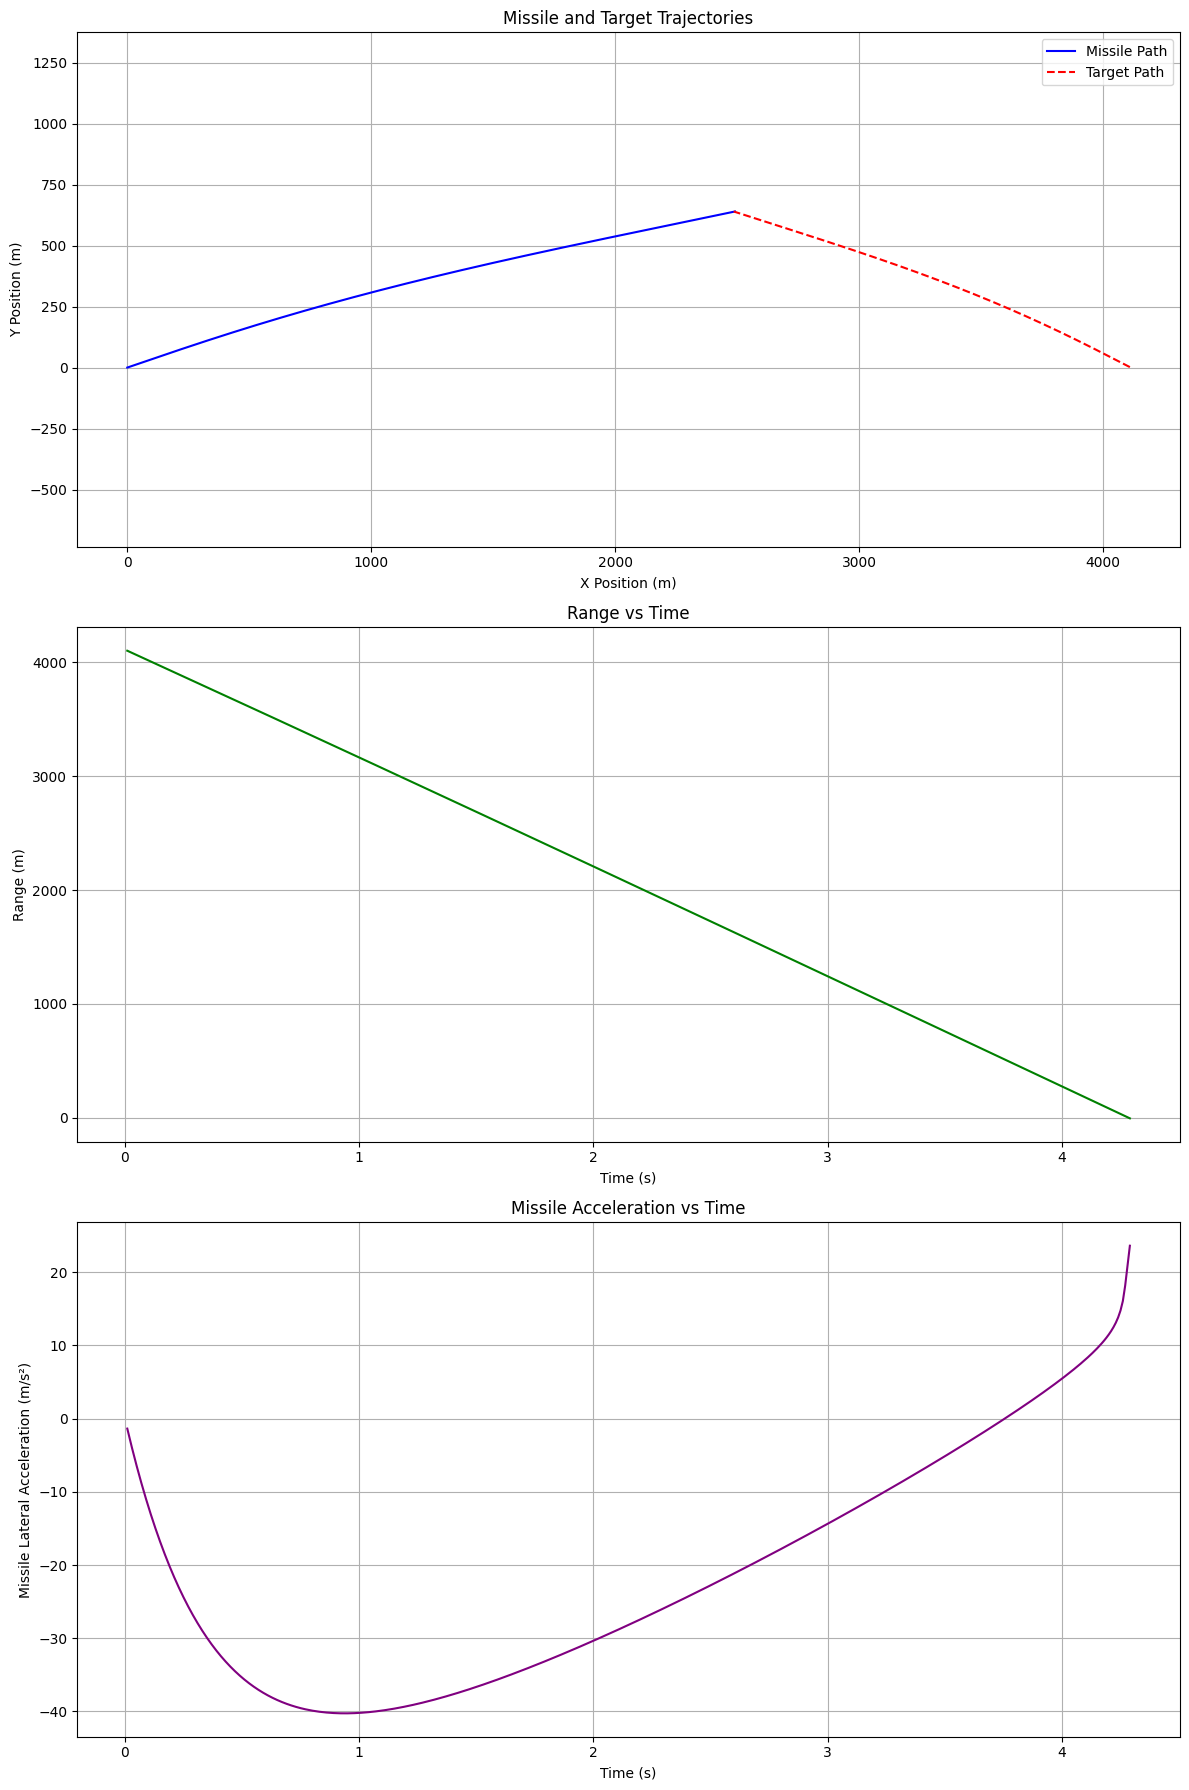

In [5]:
env = MissileGuidanceEnv(logging=True)

obs = env.reset()
done = False

while not done:
    # Example: simple proportional navigation
    r, lambda_, r_dot, lambda_dot = obs
    Nc = 3.0
    Vc = -r_dot
    ac = Nc * Vc * lambda_dot

    obs, reward, done, _ = env.step(np.array([ac]))

# Now plot everything
plot_trajectories(env)
